In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np
import pandas as pd

import torch
import torch.utils.data
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset

#needed to create the Neural Network
import torch.nn as nn
import torch.nn.functional as F

#needed to preprocess the dataset
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from dataloader import UNSW_NB15

#general
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Load the TensorBoard notebook extension
from torch.utils.tensorboard import SummaryWriter

X1 = torch.randn(1000, 50)
X2 = torch.randn(1000, 50) + 1.5
X = torch.cat([X1, X2], dim=0)
Y1 = torch.zeros(1000, 1)
Y2 = torch.ones(1000, 1)
Y = torch.cat([Y1, Y2], dim=0)
print(X.size())
print(Y.size())

torch.Size([2000, 50])
torch.Size([2000, 1])


In [57]:
df_train = pd.read_csv('UNSW_NB15_training-set.csv').drop(columns=['proto','state','service','attack_cat']).set_index('id')
df_test = pd.read_csv('UNSW_NB15_testing-set.csv').drop(columns=['proto','state','service','attack_cat']).set_index('id')

In [58]:
df_train.head(2)

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.2956,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.0,0.0,0.0,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,0
2,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.9150,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.0,0.0,0.0,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,0


In [59]:
df_train = df_train.sample(frac=1)

X_train = df_train.drop(columns='label')
y_train = df_train.label

X_test = df_test.drop(columns='label')
y_test = df_test.label

convert to torch tensors

In [60]:
X_train = torch.FloatTensor(X_train.values.astype('float'))
y_train = torch.FloatTensor(y_train.values.astype('float')).reshape((-1,1))
X_test = torch.FloatTensor(X_test.values.astype('float'))
y_test = torch.FloatTensor(y_test.values.astype('float')).reshape((-1,1))

# Model

In [35]:
# define NN architecture
class Net(nn.Module):
    
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y

In [84]:
def train_epoch(model, opt, criterion, batch_size=10000):
    model.train()
    losses = []
    for beg_i in range(0, X_train.size(0), batch_size):
        x_batch = X_train[beg_i:beg_i + batch_size, :]
        y_batch = y_train[beg_i:beg_i + batch_size, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

In [85]:
net = Net(input_size)
opt = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()

e_losses = []
num_epochs = 80
for e in tqdm(range(num_epochs)):
    e_losses.append([train_epoch(net, opt, criterion)])

<IPython.core.display.Javascript object>


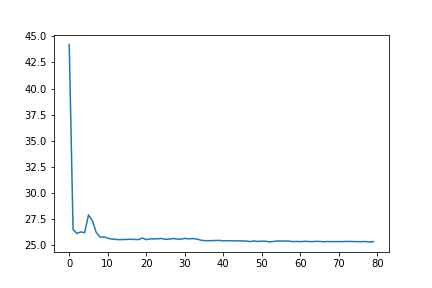

In [86]:
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in e_losses]
plt.plot(loss_per_epoch)

# Predicting time

In [87]:
y_pred = net(X_test); y_pred = y_pred.detach().numpy().flatten(); y_pred = y_pred == 1
y_true = y_test.numpy().flatten(); y_true = y_true == 1
accuracy_score(y_true, y_pred)

0.7543482485546325